# World Development Indicators and Life Expectancy in 2010

This notebook examines adult literacy worldwide and what factors lead to having a high life expectancy in the year 2010. The data used in this notebook come from [Kaggle](https://www.kaggle.com/worldbank/world-development-indicators). To start, we load in the relevant libraries and SQLite database using SQLalchemy and print the table and column names.

In [2]:
# import relevant libraries

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sqla

In [3]:
# Connect to SQLite database found in database.sqlite

metadata = sqla.MetaData()

engine =  sqla.create_engine("sqlite:///database.sqlite")

table_names = engine.table_names()

tables = dict()

for table in table_names:
    print("\n"+table+" columns:\n")
    tables[table] = sqla.Table(table, metadata, autoload=True, autoload_with=engine)
    for column in tables[table].c.keys():
        print(column)


Country columns:

CountryCode
ShortName
TableName
LongName
Alpha2Code
CurrencyUnit
SpecialNotes
Region
IncomeGroup
Wb2Code
NationalAccountsBaseYear
NationalAccountsReferenceYear
SnaPriceValuation
LendingCategory
OtherGroups
SystemOfNationalAccounts
AlternativeConversionFactor
PppSurveyYear
BalanceOfPaymentsManualInUse
ExternalDebtReportingStatus
SystemOfTrade
GovernmentAccountingConcept
ImfDataDisseminationStandard
LatestPopulationCensus
LatestHouseholdSurvey
SourceOfMostRecentIncomeAndExpenditureData
VitalRegistrationComplete
LatestAgriculturalCensus
LatestIndustrialData
LatestTradeData
LatestWaterWithdrawalData

CountryNotes columns:

Countrycode
Seriescode
Description

Footnotes columns:

Countrycode
Seriescode
Year
Description

Indicators columns:

CountryName
CountryCode
IndicatorName
IndicatorCode
Year
Value

Series columns:

SeriesCode
Topic
IndicatorName
ShortDefinition
LongDefinition
UnitOfMeasure
Periodicity
BasePeriod
OtherNotes
AggregationMethod
LimitationsAndExceptions
No

## Initial Exploratory Analysis

Once we have created an engine and loaded the tables from the database, we can then do an exploratory analysis of the data. We want to examine life expectancy, but first we must find which indicator in our table refers to this field. We use the Indicators and Series table to find indicators with the word "life expectancy" in them, and print the name of the indicator, the IndicatorCode, and a description of the Indicator.

In [4]:
# Create SQL query function (We'll use a similar query again later)

# Select distinct IndicatorNames (to avoid repeating the same indicator for each country)

def find_indicator_strings(indicator):
    stmt = sqla.select([tables["Indicators"].c.IndicatorName.distinct(), 
                        tables["Indicators"].c.IndicatorCode,
                        tables["Series"].c.LongDefinition])

    # Use JOIN to find description under series name

    stmt = stmt.select_from(
        tables["Indicators"].join(tables["Series"], 
                                 tables["Indicators"].c.IndicatorCode == tables["Series"].c.SeriesCode)
    )

    # Find indicators that have indicator somewhere

    return stmt.where(tables["Indicators"].c.IndicatorName.ilike("%"+indicator+"%"))

stmt = find_indicator_strings("life expectancy")

# Connect to the engine and execute the statement.

conn = engine.connect()

for result in conn.execute(stmt):
    print(result.IndicatorName, result.IndicatorCode)
    print(result.LongDefinition)
    print("\n")

conn.close()

Life expectancy at birth, female (years) SP.DYN.LE00.FE.IN
Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.


Life expectancy at birth, male (years) SP.DYN.LE00.MA.IN
Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.


Life expectancy at birth, total (years) SP.DYN.LE00.IN
Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.




From these queries, we have identified that the indicator that most closely matches our query is the life expectancy at birth, which has the code SP.DYN.LE00.IN. We then use this to select this literacy rate for the year 2010 and plot it on a histogram.

C:\Users\aawie\AppData\Local\Continuum\Anaconda3\lib\site-packages\sqlalchemy\sql\sqltypes.py:596: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
CountryName       200 non-null object
LifeExpectancy    200 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.2+ KB
None
       LifeExpectancy
count      200.000000
mean        70.281327
std          8.947131
min         47.483415
25%         64.771524
50%         72.798463
75%         76.722341
max         83.159379


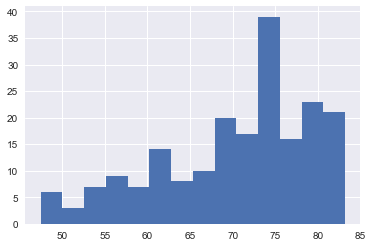

In [5]:
%matplotlib inline
# Create SQL query

stmt = sqla.select([tables["Indicators"].c.CountryName, tables["Indicators"].c.Value.label("LifeExpectancy")])


# Use to avoid selecting regions instead of countries
stmt = stmt.select_from(tables["Indicators"].join(tables["Country"],
                                                 tables["Country"].c.CountryCode == tables["Indicators"].c.CountryCode))

stmt = stmt.where(sqla.and_(tables["Country"].c.Region.isnot(""),
                            tables["Indicators"].c.IndicatorCode == "SP.DYN.LE00.IN",
                            tables["Indicators"].c.Year == 2010)
    )


conn = engine.connect()

# Load into pandas dataframe

life_exp = pd.read_sql_query(stmt, conn)

print(life_exp.info())
print(life_exp.describe())


plt.hist(life_exp["LifeExpectancy"], bins = 14)

conn.close()

From our histogram and description of the dataset, we can see that the mean life expectancy in 2010 was about 70, although the distribution is skewed to the right since median is actually almost 73 years.

## Exploring possible predictors

We then would like to query for other available indicators so that later we can use machine learning to try to understand what may predict life expectancy. Using our earlier function we defined to try to find several different predictors. Here, we look for infant mortality, fertility, population density, GDP per capita, PM2.5 Exposure, and CO2 emissions.

In [10]:
# Create list to look through
string_list = ["infant", "fertility", "population density", "GDP per capita", "PM2.5", "CO2 emissions"]

conn = engine.connect()

for string in string_list:
    print(string+"\n")
    stmt = find_indicator_strings(string)
    for result in conn.execute(stmt):
        print(result.IndicatorName, result.IndicatorCode)
        print(result.LongDefinition)
        print("\n")

conn.close()
    

infant

Completeness of infant death reporting (% of reported infant deaths to estimated infant deaths) SP.DTH.INFR.ZS
Completeness of infant death reporting is the number of infant deaths reported by national statistics authorities to the United Nations Statistics Division's Demography Yearbook divided by the number of infant deaths estimated by the United Nations Population Division.


Mortality rate, infant (per 1,000 live births) SP.DYN.IMRT.IN
Infant mortality rate is the number of infants dying before reaching one year of age, per 1,000 live births in a given year.


Mortality rate, infant, female (per 1,000 live births) SP.DYN.IMRT.FE.IN
Infant mortality rate, female is the number of female infants dying before reaching one year of age, per 1,000 female live births in a given year.


Mortality rate, infant, male (per 1,000 live births) SP.DYN.IMRT.MA.IN
Infant mortality rate, male is the number of male infants dying before reaching one year of age, per 1,000 male live births in 

Here, we select Mortality rate, infant (per 1,000 live births) SP.DYN.IMRT.IN, Fertility rate, total (births per woman) SP.DYN.TFRT.IN, Population density (people per sq. km of land area) EN.POP.DNST, GDP per capita, PPP (constant 2011 international dollars) NY.GDP.PCAP.PP.KD, PM2.5 air pollution, mean annual exposure (micrograms per cubic meter) EN.ATM.PM25.MC.M3, and CO2 emissions (kg per 2011 PPP dollars of GDP) EN.ATM.CO2E.PP.GD.KD. (In practice, we sould likely select many more, but many of these indicators would probably covary.)

In [29]:
%matplotlib inline

# Create dictionary of codes we wish to query to human readable names

code_dict = {"SP.DYN.LE00.IN" : "LifeExpectancy", 
             "SP.DYN.IMRT.IN" : "InfantMort",
             "SP.DYN.TFRT.IN" : "Fertility",
             "EN.POP.DNST" : "PopDens",
             "NY.GDP.PCAP.PP.KD" : "GDPperCap",
             "EN.ATM.PM25.MC.M3" : "PM2.5Exp",
             "EN.ATM.CO2E.PP.GD.KD" : "CO2"}

# Create SQL query

stmt = sqla.select([tables["Indicators"].c.CountryName, 
                    tables["Indicators"].c.IndicatorCode.label("Indicator"),
                    tables["Indicators"].c.Value])


# Use to avoid selecting regions instead of countries
stmt = stmt.select_from(tables["Indicators"].join(tables["Country"],
                                                 tables["Country"].c.CountryCode == tables["Indicators"].c.CountryCode))

stmt = stmt.where(sqla.and_(tables["Country"].c.Region.isnot(""),
                            tables["Indicators"].c.IndicatorCode.in_(list(code_dict.keys())),
                            tables["Indicators"].c.Year == 2010)
    )

conn = engine.connect()

life_exp = pd.read_sql_query(stmt, conn)

# Change codes to readable names
life_exp["Indicator"].replace(code_dict, inplace=True)

# Change from long to wide format
life_exp = life_exp.pivot(index="CountryName", columns = "Indicator", values = "Value")

# Remove NA values
life_exp.dropna(inplace=True)

print(life_exp.info())
print(life_exp.describe())



conn.close()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, Afghanistan to Zimbabwe
Data columns (total 7 columns):
CO2               177 non-null float64
Fertility         177 non-null float64
GDPperCap         177 non-null float64
InfantMort        177 non-null float64
LifeExpectancy    177 non-null float64
PM2.5Exp          177 non-null float64
PopDens           177 non-null float64
dtypes: float64(7)
memory usage: 11.1+ KB
None
Indicator         CO2   Fertility      GDPperCap  InfantMort  LifeExpectancy  \
count      177.000000  177.000000     177.000000  177.000000      177.000000   
mean         0.258143    2.945248   16511.548649   27.841243       69.848042   
std          0.181522    1.471057   18820.022901   24.918541        8.817252   
min          0.022593    1.150000     596.322848    1.900000       47.483415   
25%          0.141116    1.820000    3240.831521    7.600000       63.402293   
50%          0.220387    2.465000   10031.644562   17.100000       72.567512   
75%   

Although we lost some data by removing missing values, we now have a dataset that we can explore further to see how they might predict Life Expectancy. We first may want to check which predictors are correlated with LifeExpetancy and which predictors are correlated with each other. For the latter, we want to check for possible covariance. For example, countries that are richer might emit more CO2, so GDP per capita might also be related to CO2 emissions per GDP. 

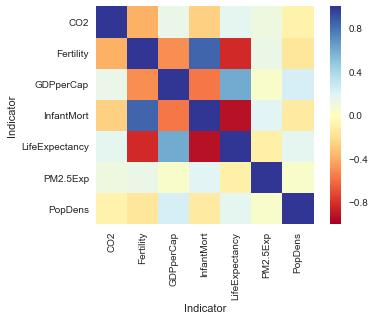

In [32]:
%matplotlib inline

sns.heatmap(life_exp.corr(), square=True, cmap='RdYlBu')

Certainly, each variable is highly correlated with itself. However, it seems PM2.5 Exposure and Population density are only weakly correlated to each other variable. Of the variables shown here, Fertility, GDP per Capita, and Infant Mortality seem most strongly correlated with LifeExpectancy. However, each of these also seem to be highly interrelated as shown by the more intense blue/orange colors. 